In [10]:
# imports and basic config

from collections import OrderedDict
import datetime
import traceback
import regex as re
import requests
import feedparser
from bs4 import BeautifulSoup
from polyglot.text import Text
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from bidi import algorithm as bidialg
import arabic_reshaper

In [15]:
# Configures how long into the past to go from today. 1 = just today, 2 = today and yesterday, etc. 
# Note that this tool currently relies on RSS feeds to scrape articles, and RSS feeds only list recent content.
# As a result, setting this to go into the far past will not work.
number_of_days_to_include = 2

dates = []
date_tuples = set()

today = datetime.date.today()
d = today
for i in range(0, number_of_days_to_include):
    dates.append(d)
    date_tuples.add((d.year, d.month, d.day))
    d = d - datetime.timedelta(days=1)

if len(date_tuples) == 1:
    date_str = str(dates[0])
else: 
    date_str = str(dates[len(dates) - 1]) + ' to ' + str(dates[0])
    
print('Scraping and analyzing data from %s...' % date_str)

Scraping and analyzing data from 2018-08-26 to 2018-08-27...


In [16]:
# gets today's articles from the rss feeds

feeds = {
    'Sputnik (English)': 'https://sputniknews.com/export/rss2/archive/index.xml',
    'Sputnik (Arabic)': 'https://arabic.sputniknews.com/export/rss2/archive/index.xml',
    'Sputnik (German)': 'https://de.sputniknews.com/export/rss2/archive/index.xml',
    'Sputnik (Polish)': 'https://pl.sputniknews.com/export/rss2/archive/index.xml',
}
article_links_by_feed = {}

for feed, url in feeds.items():
    rss = feedparser.parse(url)

    # gets all articles from today
    article_links_by_feed[feed] = {
        entry['title']: entry['link'] 
        for entry in rss['entries']
        if (entry['published_parsed'].tm_year, entry['published_parsed'].tm_mon, entry['published_parsed'].tm_mday) in date_tuples
    }
    
    print('Found %d articles in %s from %s' % (len(article_links_by_feed[feed]), feed, date_str))


Found 140 articles in Sputnik (English) from 2018-08-26 to 2018-08-27
Found 150 articles in Sputnik (Arabic) from 2018-08-26 to 2018-08-27
Found 79 articles in Sputnik (German) from 2018-08-26 to 2018-08-27
Found 52 articles in Sputnik (Polish) from 2018-08-26 to 2018-08-27


In [18]:
# fetches today's articles over http

article_html_by_feed = {feed: {} for feed in feeds.keys()}

for feed, article_links in article_links_by_feed.items():
    for title, link in article_links.items():
        result = requests.get(link)
        if result.status_code == 200:
            article_html_by_feed[feed][title] = result.text
        else: 
            print('Error: Got status %d from %s' % (result.status_code, link))
            


In [19]:
# parses today's articles with beautifulsoup in order to extract main body of article

article_bodies_by_feed = {feed: {} for feed in feeds.keys()}

for feed, articles_html in article_html_by_feed.items():
    for title, html in articles_html.items(): 
        bs = BeautifulSoup(html, 'lxml')
        body_div = bs.find('div', attrs={'itemprop': 'articleBody'})
        ps = [child.text for child in body_div.findChildren('p', recursive=False)]
        body = '\n\n'.join(ps)
        article_bodies_by_feed[feed][title] = body
        


In [20]:
# extracts named entities from article bodies

named_entities = []

for feed, article_bodies in article_bodies_by_feed.items():
    for title, body in article_bodies.items():
        
        try:
            txt = Text(body)
            entities = txt.entities

            for e in entities: 
                # filters to only tokens that have at least one letter in them
                filtered = list(filter(lambda x: re.search('\p{L}', x), e))

                e_str = ' '.join(filtered).replace('.', '').strip()
                
                # special treatment for arabic and persian so that matplotlib will render them right-to-left in cursive
                if txt.language.name in ('Arabic', 'Persian'):
                    e_str = arabic_reshaper.reshape(e_str)
                    e_str = bidialg.get_display(e_str)

                if e_str != '':
                    named_entities.append([feed, title, e.tag, e_str])
        except Exception as e:
            print('Warning: skipping article "%s". Couldn\'t extract entities from it: %s' % (title, e))
            
named_entities = pd.DataFrame(columns=['feed', 'article', 'entity_type', 'entity'], data=named_entities)


Detector is not able to detect the language reliably.


Detector is not able to detect the language reliably.


Detector is not able to detect the language reliably.


Detector is not able to detect the language reliably.


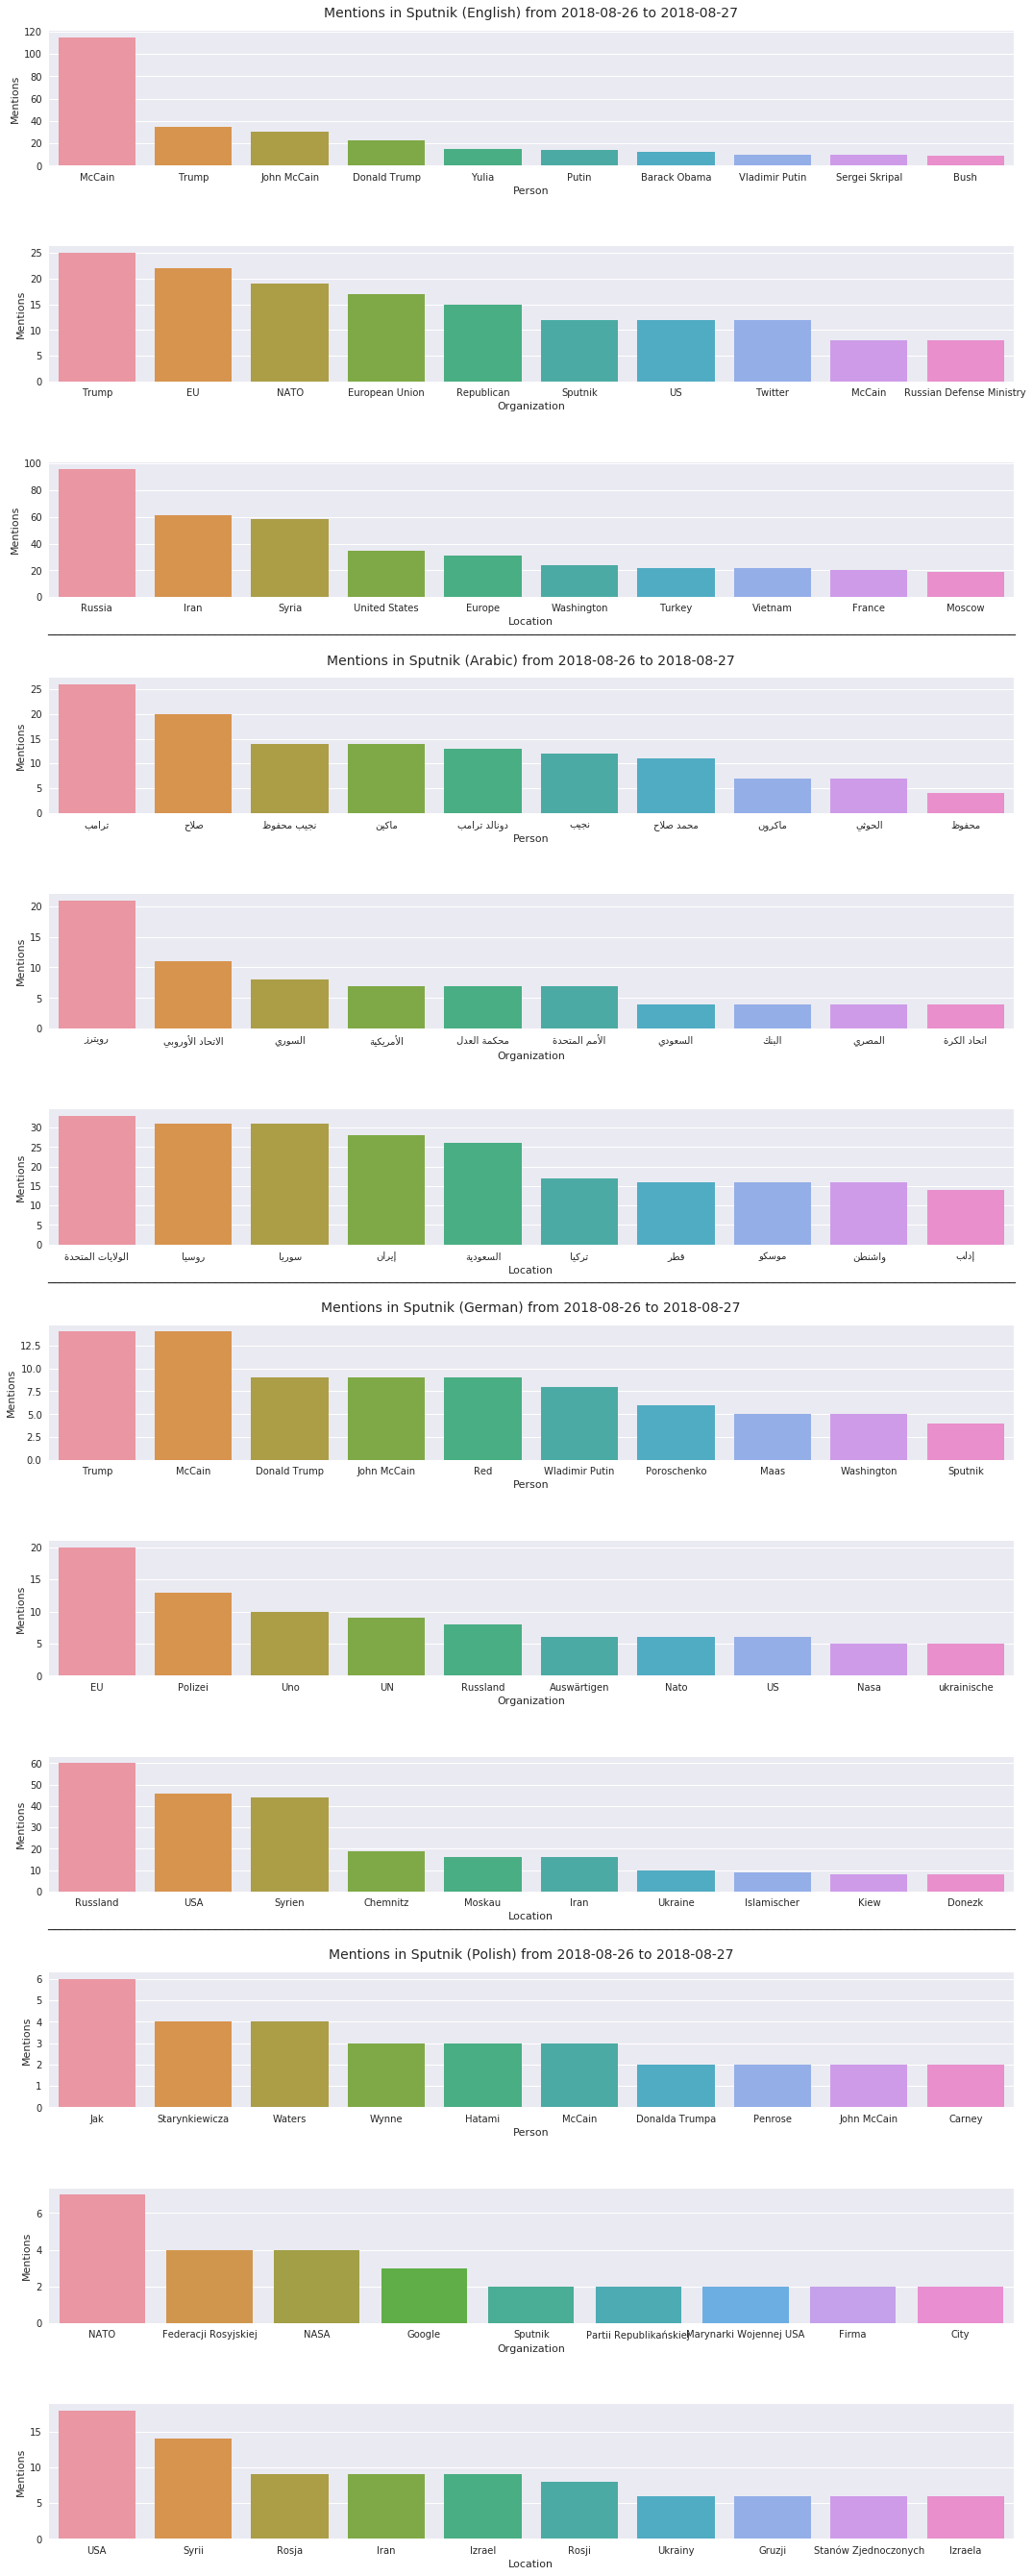

In [21]:
# Plots the top-n mentioned entities in each category for each feed

# config values for the plot's labels
tag_display_info = OrderedDict({
    'I-PER': {'tag_name': 'Person'}, 
    'I-ORG': {'tag_name': 'Organization'},
    'I-LOC': {'tag_name': 'Location'}, 
})
y_name = 'Mentions'
# defines how many of the top-mentioned entities we should display
top_n = 10
separator = ''.join(list(map(lambda x: '_', range(0, 144)))) + '\n\n'

# defines the layout of the plots
fig, ax = plt.subplots(3 * len(feeds), 1)
fig.set_size_inches(18 , 12 * len(feeds))
plt.subplots_adjust(hspace=0.6)
sns.set(style="darkgrid")

i = 0
for feed in feeds:
    
    # Puts a title in the plots for this feed
    title = 'Mentions in %s from %s' % (feed, date_str)
    if i != 0: 
        title = separator + title
    plt.text(0.5, 1.1, title, horizontalalignment='center', transform=ax[i].transAxes, fontsize=14)

    feed_entities = named_entities.loc[named_entities['feed'] == feed]
    
    # creates a plot for each of the three entity types
    for entity_type in tag_display_info.keys():
        tag_display_name = tag_display_info.get(entity_type, {'tag_name': entity_type})['tag_name']
        
        typed_entities = feed_entities.loc[feed_entities['entity_type'] == entity_type]
        entity_counts = typed_entities['entity'].value_counts(sort=True).to_frame().rename(columns={'entity':y_name})
        entity_counts[tag_display_name] = entity_counts.index
        
        top = entity_counts[entity_counts[y_name] > 1].head(top_n)
        sns.barplot(x=tag_display_name, y=y_name, data=top, ax = ax[i])
        i += 1